# DT8122 - Assignment

<span style="color:red">Deadline: 2023 August 15 AoE (Anywhere on Earth)</span>

Send a zip file with the notebook both as a .ipynb and as a .pdf file to <a href="mailto:dt8122@idi.ntnu.no">dt8122@idi.ntnu.no</a>. Label the file with your full name.

The task is to implement conditional DDPM for MNIST images. Your implementation should take as input a digit and be able to generate 28x28 grayscale handwritten image of said digit. 

You can add additional cells anywhere in the notebook to make your code more readable.

DDPM: https://arxiv.org/abs/2006.11239

Classifier-free conditional DDPM: https://arxiv.org/abs/2207.12598

The notebook should be run when it is turned in so all plots are visible. All code should be contained in the notebook.


### Install necessary libraries
Any additional libraries you make use of should be installed in this cell.

### Import libraries
All import statements should be contained here.

In [1]:
import random
import math
import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST

/home/sigmund/miniconda3/envs/calvin_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define constants here
Constants such as number of epochs, device, and learning rate and other hyperparameters should be defined here. We also define the parameters for the diffusion process.

In [2]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(f'Using device: {device}')

# Hyperparameters
batch_size = 64
num_epochs = 20
lr = 1e-3

# Diffusion parameters
beta_min = 1e-4
beta_max = 1e-2
num_diff_steps = 1000
mask_probability = 0.2

Using device: cuda


### Functionality for loading and visualizing dataset
We have provided some functionality for loading and visualizing the dataset. You may add more cells/functions here.

In [3]:
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
dataset = MNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [4]:
"""
This function plots images in a grid. Input is a Tensor.
See show_first_batch to see how it is used.
"""
def show_images(images, title=""):
    images = images.detach().cpu().numpy()
    fig = plt.figure(figsize=(4, 4))
    cols = math.ceil(len(images) ** (1 / 2))
    rows = math.ceil(len(images) / cols)
    for r in range(rows):
        for c in range(cols):
            idx = cols * r + c
            ax = fig.add_subplot(rows, cols, idx + 1)
            ax.axis('off')
            if idx < len(images):
                ax.imshow(images[idx][0], cmap="gray")
    fig.suptitle(title, fontsize=18)
    plt.show()

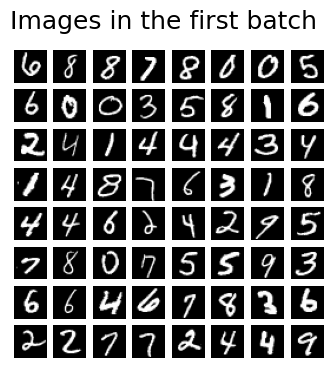

In [5]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break
show_first_batch(loader)

### Your conditional DDPM implementation should go here
This includes functionality for adding noise to the image.

In [6]:
def get_alpha_bars(beta_min, beta_max, num_diff_steps):
    betas = torch.linspace(beta_min, beta_max, num_diff_steps)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim = 0)
    return betas, alphas, alpha_bars

betas, alphas, alpha_bars = get_alpha_bars(beta_min, beta_max, num_diff_steps)
betas = betas.to(device)
alphas = alphas.to(device)
alpha_bars = alpha_bars.to(device)

torch.Size([2, 1, 28, 28])


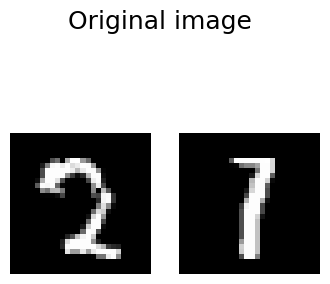

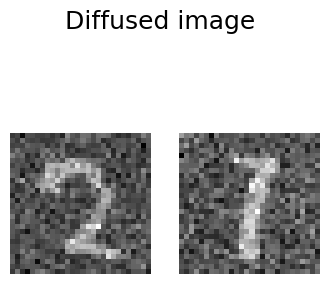

In [7]:
def forward_diffusion(x_0, alpha_bars, noise):
    assert x_0.shape[0] == alpha_bars.shape[0], f"Shape of x_0: {x_0.shape}, shape of alpha_bars: {alpha_bars.shape}"
    alpha_bars = alpha_bars.view(-1, 1, 1, 1)
    x_t = torch.sqrt(alpha_bars) * x_0 + torch.sqrt(1 - alpha_bars) * noise
    return x_t

# Test forward_diffusion for an image
x_0 = next(iter(loader))[0][0:2].to(device)
print(x_0.shape)
show_images(x_0, "Original image")
noise = torch.randn_like(x_0)
x_t = forward_diffusion(x_0, alpha_bars[200:202], noise)
show_images(x_t, "Diffused image")

### The implementation of the neural network used to estimate the noise should go here
The network should make use of both time and context embedding.

Any functions/methods used for time and context embeddings should also go here.

In [8]:
def temporal_encoding(num_ts, d_emb):
    """
    Returns the temporal sinusoidal encoding for all 
    timesteps up to num_ts, with d_emb dimensions.

    This only needs to be computed once, and get_temporal_encoding
    can be used to retrieve the encoding for a particular timestep.
    
    Args:
        d_emb (int): The number of dimensions in the embedding.
        num_ts (int): The number of timesteps to encode.
    Returns:
        torch.Tensor (d_emb, num_ts): A tensor representing the sinusoidal encoding for all timesteps.

    """

    positions = torch.arange(num_ts).reshape(num_ts, 1)
    div_term = torch.exp(- torch.arange(0,d_emb, 2) * math.log(10000.0)/d_emb)
    pe = torch.zeros(num_ts, d_emb)
    sin_terms = torch.sin(positions * div_term) # (num_ts, d_emb/2)
    cos_terms = torch.cos(positions * div_term) # (num_ts, d_emb/2)
    pe[:, ::2] = sin_terms
    pe[:, 1::2] = cos_terms
    return pe

In [9]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    """Used for embedding context and diffusion time step"""
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    """ Based on this architecture: https://github.com/TeaPearce/Conditional_Diffusion_MNIST/blob/main/script.py"""
    def __init__(self, in_channels, n_feat = 256, n_classes=10, num_diff_steps=1000, time_emb_dim=100):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        # Sinusoidal temporal embeddings
        self.time_embed = nn.Embedding(num_diff_steps, time_emb_dim)
        self.time_embed.weight.data = temporal_encoding(num_diff_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        self.timeembed1 = EmbedFC(time_emb_dim, 2*n_feat)
        self.timeembed2 = EmbedFC(time_emb_dim, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t):
        # x is (noisy) image, c is context label, t is timestep, 
        # context_mask says which samples to block the context on
        x = self.init_conv(x)
        t = self.time_embed(t)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)
        
        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        #print("shape of cemb1", cemb1.shape)
        #print("shape of up1", up1.shape)
        #print("shape of temb1", temb1.shape)
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out


In [10]:
model = ContextUnet(in_channels=1, n_feat=256, n_classes=10, num_diff_steps=1000, time_emb_dim=100).to(device)

### Show that you can generate images before the model is trained
This should demonstrate that the backwards pass works. The generated images are expected to be noise.

/tmp/ipykernel_1890189/3470189635.py:7: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for t in tqdm.tqdm(torch.range(num_diff_steps-1, 0, -1, dtype=torch.long, device=device)):
100%|██████████| 1000/1000 [00:07<00:00, 125.76it/s]


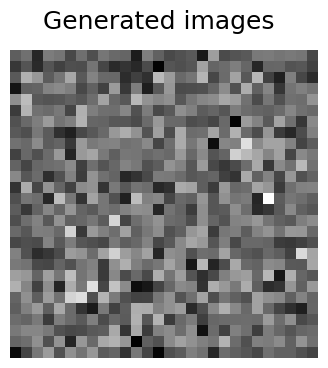

In [11]:
def generate_images_discrete(model, class_label):
    w = 3.0
    x = torch.randn(1, 1, 28, 28).to(device)
    c = F.one_hot(torch.tensor(class_label), 10).float().to(device)
    c_uncond = torch.zeros(1, 10).to(device)
    with torch.no_grad():
        for t in tqdm.tqdm(torch.range(num_diff_steps-1, 0, -1, dtype=torch.long, device=device)):
            if t > 0:
                z = torch.randn(1, 1, 28, 28).to(device)
            else:
                z = torch.zeros(1, 1, 28, 28).to(device)
            alpha_t = alphas[t]
            alpha_bar_t = alpha_bars[t]
            beta_t = betas[t]
            #Convert t to float
            #t = t.float().to(device)
            noise_pred_uncond = model(x,c_uncond,t)
            noise_pred = model(x,c,t)
            noise_pred_weighted = (1+w)*noise_pred - w*noise_pred_uncond
            x = 1/torch.sqrt(alpha_t) * (x - ((1-alpha_t)/torch.sqrt(1 - alpha_bar_t)) * noise_pred_weighted) + torch.sqrt(beta_t) * z
    return x
x = generate_images_discrete(model, 0)
show_images(x, "Generated images")

### Implement training loop
Train the model here. There should be some indication of how long the model took to train, both total and per epoch. For good results you will want to train the model for several epochs, but with a good implementation you should expect to see something that looks like digits after only a single epoch.

In [12]:
def mask_classes(y, mask_probability):
    """Takes in (batch_size, 1), converts to 1-hot and masks
    out with probability mask_probability, returns (batch_size, 10)
    """
    
    context_mask = torch.bernoulli(torch.zeros_like(y) + mask_probability)
    # convert context to one hot embedding
    y = nn.functional.one_hot(y, num_classes=10).type(torch.float)
    # mask out context if context_mask == 1
    context_mask = context_mask[:, None]
    context_mask = context_mask.repeat(1,10)
    #print first few context masks
    #print("context mask", context_mask[:5])
    context_mask = (1-context_mask) # need to flip 0 <-> 1
    #print("context mask", context_mask[:5])
    y = y * context_mask
    #print("classes after masking", y[:5])
    return y

#### Training the model

In [13]:
def train(model, loader, num_epochs, lr, mask_probability):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    losses = []
    for epoch in range(num_epochs):
        progress_bar = tqdm.tqdm(loader, desc=f"Epoch {epoch}")
        for batch in progress_bar:
            optimizer.zero_grad()
            x, y = batch
            x = x.to(device)
            masked_y = mask_classes(y, mask_probability).to(device)
            eps = torch.randn_like(x).to(device)
            n = len(x)
            # sample ts as torch.long from a uniform distribution
            ts = torch.randint(0, num_diff_steps, (n,), dtype=torch.long).to(device)
            alpha_bars_ts = alpha_bars[ts]
            #ts = ts.float().to(device)
            
            preds = model(forward_diffusion(x, alpha_bars_ts, eps), masked_y, ts)
            loss = criterion(preds, eps)
            
            # log the loss
            losses.append(loss.item())
            progress_bar.set_postfix(loss=loss.item())
            #print(f"Epoch {epoch}, Loss {loss.item()}")

            loss.backward()
            optimizer.step()
            
    plt.plot(losses)

### Train and visualize the model
We want to see several generated examples of each digit.

Epoch 19: 100%|██████████| 938/938 [01:24<00:00, 11.08it/s, loss=0.0269]


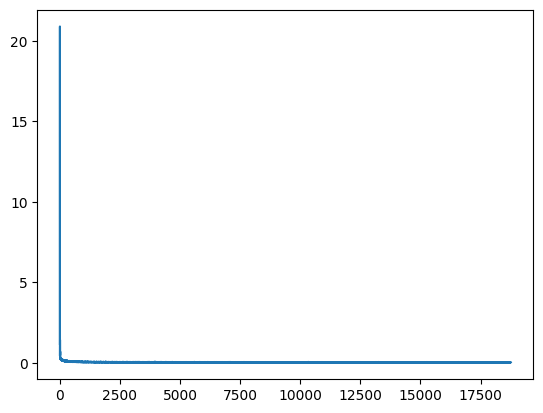

In [14]:
train(model, loader, num_epochs, lr, mask_probability)

In [15]:
# save the model
torch.save(model.state_dict(), "conditional_ddpm.pt")

/tmp/ipykernel_1890189/3470189635.py:7: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for t in tqdm.tqdm(torch.range(num_diff_steps-1, 0, -1, dtype=torch.long, device=device)):
100%|██████████| 1000/1000 [00:07<00:00, 132.76it/s]


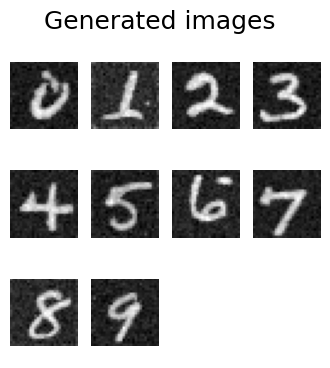

In [16]:
generated_images = []
for i in range(10):
    x = generate_images_discrete(model, i)
    generated_images.append(x)

show_images(torch.cat(generated_images), "Generated images")
